In [1]:
import os

dataset_path = "/kaggle/input/brain-tumor-mri-dataset/"

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for file in files[:5]:  # Show first 5 files to keep it clean
        print(f"{subindent}{file}")


/
Training/
    pituitary/
        Tr-pi_0532.jpg
        Tr-pi_0282.jpg
        Tr-pi_1401.jpg
        Tr-pi_0914.jpg
        Tr-pi_0691.jpg
    notumor/
        Tr-no_0482.jpg
        Tr-no_0641.jpg
        Tr-no_0592.jpg
        Tr-no_0711.jpg
        Tr-no_0746.jpg
    meningioma/
        Tr-me_0529.jpg
        Tr-me_1256.jpg
        Tr-me_0852.jpg
        Tr-me_0494.jpg
        Tr-me_1293.jpg
    glioma/
        Tr-gl_0954.jpg
        Tr-gl_0959.jpg
        Tr-gl_1033.jpg
        Tr-gl_1096.jpg
        Tr-gl_1290.jpg
Testing/
    pituitary/
        Te-pi_0059.jpg
        Te-pi_0024.jpg
        Te-pi_0232.jpg
        Te-pi_0286.jpg
        Te-pi_0233.jpg
    notumor/
        Te-no_0016.jpg
        Te-no_0292.jpg
        Te-no_0137.jpg
        Te-no_0346.jpg
        Te-no_0141.jpg
    meningioma/
        Te-me_0148.jpg
        Te-me_0062.jpg
        Te-me_0303.jpg
        Te-me_0179.jpg
        Te-me_0089.jpg
    glioma/
        Te-gl_0066.jpg
        Te-gl_0043.jpg
        Te-gl_01

Categories: ['pituitary', 'notumor', 'meningioma', 'glioma']
pituitary: 1457 training images
notumor: 1595 training images
meningioma: 1339 training images
glioma: 1321 training images


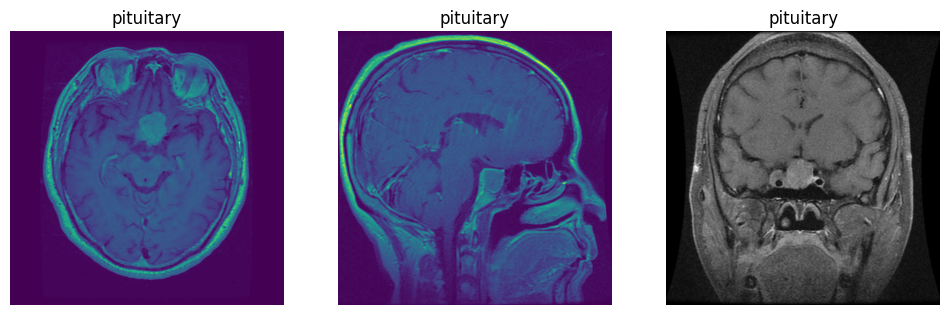

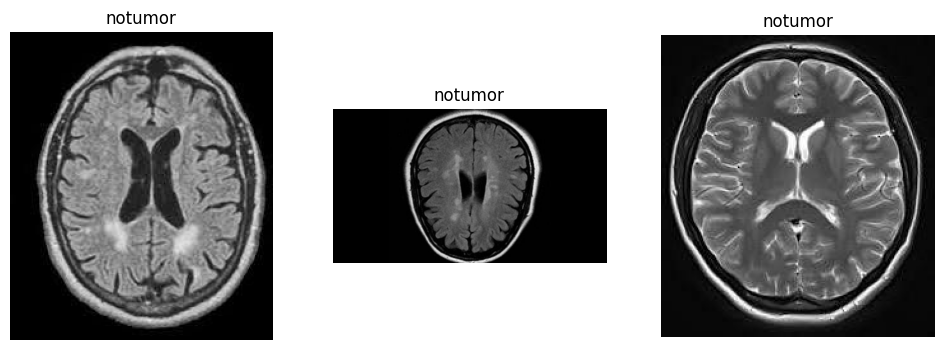

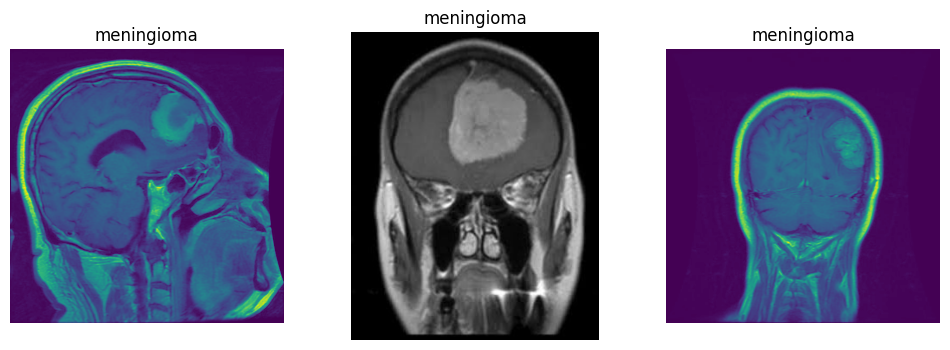

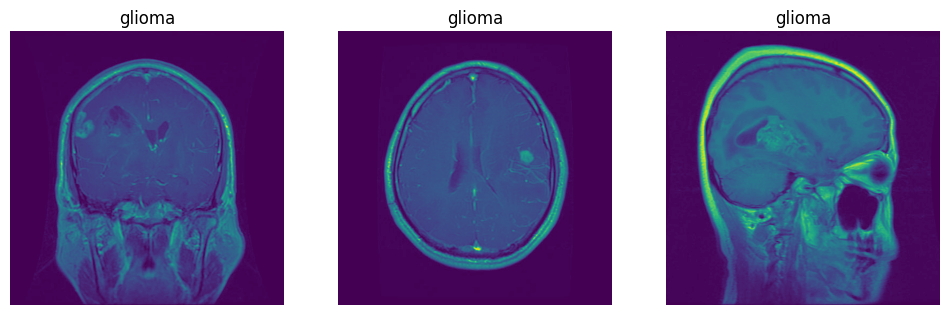

In [2]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

dataset_path = "/kaggle/input/brain-tumor-mri-dataset/"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

# List of categories
categories = os.listdir(train_path)
print("Categories:", categories)

# Count images per class
for category in categories:
    count = len(os.listdir(os.path.join(train_path, category)))
    print(f"{category}: {count} training images")

# Function to show sample images
def show_images(folder_path, title):
    images = random.sample(os.listdir(folder_path), 3)
    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{title}")
        plt.axis("off")
    plt.show()

# Show 3 images from each category
for category in categories:
    category_path = os.path.join(train_path, category)
    show_images(category_path, category)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size expected by VGG16
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


2025-07-26 14:43:58.056198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753541038.248885      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753541038.309961      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 base model without top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False

# Build the full model
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


I0000 00:00:1753541090.065257      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
EPOCHS = 14  # You can increase later if needed

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/14


I0000 00:00:1753541136.900774     116 service.cc:148] XLA service 0x7ba9cc00f2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753541136.901745     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753541137.276122     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.2422 - loss: 1.7878 

I0000 00:00:1753541145.681744     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 562ms/step - accuracy: 0.6626 - loss: 0.8432 - val_accuracy: 0.8368 - val_loss: 0.4506
Epoch 2/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.8401 - loss: 0.4505 - val_accuracy: 0.8459 - val_loss: 0.4131
Epoch 3/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 370ms/step - accuracy: 0.8699 - loss: 0.3556 - val_accuracy: 0.8612 - val_loss: 0.3854
Epoch 4/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 371ms/step - accuracy: 0.8775 - loss: 0.3289 - val_accuracy: 0.8741 - val_loss: 0.3489
Epoch 5/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 366ms/step - accuracy: 0.8803 - loss: 0.3214 - val_accuracy: 0.8894 - val_loss: 0.2936
Epoch 6/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 368ms/step - accuracy: 0.8944 - loss: 0.2879 - val_accuracy: 0.8947 - val_loss: 0.2838
Epoch 7/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 371ms/step - accuracy: 0.9007 - loss: 0.2753 - val_accuracy: 0.8894 - val_loss: 0.2925
Epoch 8/14
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 368ms/step - accuracy: 0.9041 - loss: 0.2601 - va

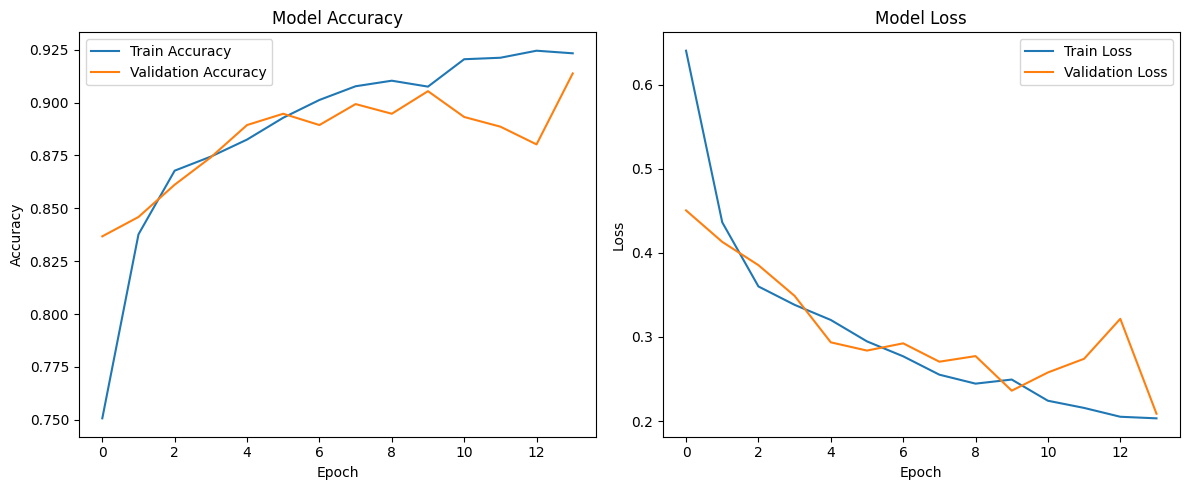

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# Save the model to the working directory
model.save("brain_tumor_classifier_vgg16.h5")

print("Model saved as brain_tumor_classifier_vgg16.h5")


Model saved as brain_tumor_classifier_vgg16.h5


In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
class_labels = list(train_generator.class_indices.keys())

def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Show image and prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class
print("Fcuntion Created ! ") 

Fcuntion Created ! 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


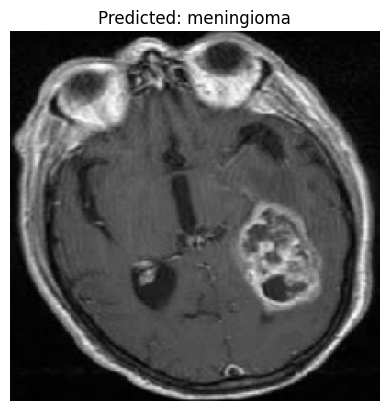

'meningioma'

In [14]:
img_path1 = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg' 
predict_image(img_path1) 